<a href="https://colab.research.google.com/github/Sidhtang/30-day-ml-challenge-/blob/main/day_26_dealing_with_no_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# in weight pruning  we look at how we can shrinl the number of parameters
# in our model bty identifying and removing the least importnt weights of our network

In [ ]:
# few questions to be con=sidered while pruning the weigh
# which weigh should be eliminated?
# how should the remaining weights be adjusted for the best performance
#answer to these questions depend on the score matirx

In [ ]:
# the problem with magnityude pruning is that
# it is purely designed for superf=vised learning
#n transfer learning the importance of the weights is primarily deter‐
 #mined by the pretraining phase, so magnitude pruning can remove connections that
 #are important for the fine-tuning task

In [ ]:
# @title  movement pruning
#  the   baic idea behin this is to gradually remove weights during
# fine  tuneing


In [ ]:
# neural networks  block movement pruning implement these ideas

In [ ]:
import pandas as pd
dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")


DataFrame shape: (9930, 26)


In [ ]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [ ]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [ ]:
df_issues["labels"] = (df_issues["labels"]
 .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [ ]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [ ]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head(8).T


Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


In [ ]:
label_map = {"Core: Tokenization": "tokenization",
 "New model": "new model",
 "Core: Modeling": "model training",
 "Usage": "usage",
 "Core: Pipeline": "pipeline",
 "TensorFlow": "tensorflow or tf",
 "PyTorch": "pytorch",
 "Examples": "examples",
 "Documentation": "documentation"}
def filter_labels(x):
 return [label_map[label] for label in x if label in label_map]
df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())


In [ ]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


In [ ]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [ ]:
for column in ["title", "body", "labels"]:
 print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [ ]:
df_issues["text"] = (df_issues
 .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

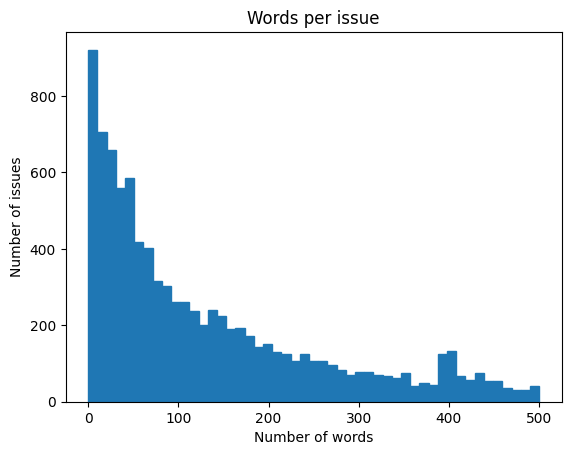

In [ ]:
# to remove duplicates from our data
import numpy as np
import matplotlib.pyplot as plt
(df_issues["text"].str.split().apply(len)
.hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()


In [ ]:
# @title Creating training sets

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
def balanced_split(df, test_size=0.5):
 ind = np.expand_dims(np.arange(len(df)), axis=1)
 labels = mlb.transform(df["labels"])
 ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
 test_size)
 return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]


In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
!pip uninstall pyarrow -y
!pip install pyarrow

Found existing installation: pyarrow 17.0.0
Uninstalling pyarrow-17.0.0:
  Successfully uninstalled pyarrow-17.0.0
  Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (39.9 MB)
ERROR: Operation cancelled by user


In [ ]:
from sklearn.model_selection import train_test_split
df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]
np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [ ]:
!pip uninstall pyarrow datasets -y
!pip install pyarrow==10.0.1 datasets

Found existing installation: datasets 2.21.0
Uninstalling datasets-2.21.0:
  Successfully uninstalled datasets-2.21.0


In [ ]:
from datasets import Dataset, DatasetDict
ds = DatasetDict({
 "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
 "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
 "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
 "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

In [ ]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0
for i, k in enumerate(train_samples):
 # Split off samples necessary to fill the gap to the next split size
 indices_pool, labels, new_slice, _ = iterative_train_test_split(
 indices_pool, labels, (k-last_k)/len(labels))
 last_k = k
 if i==0: train_slices.append(new_slice)
 else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

In [ ]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])


In [ ]:
# @title  implementing a naive basleine
# a baseline based on regular expressions handcrafted ru
# baseline provides a quickk checks as yoy exlore miore complex

In [ ]:
def prepare_labels(batch):
  batch["labels"] = mlb.transform(batch["labels"])
  return batch
  ds = ds.map(prepare_labels,batched = True)
  from collections import defaultdict
  macro_scores,micro_scores = defaultdict(list),defaultdict(list)

In [ ]:
# fianlly ready to train our baseline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
 #There’s quite a lot going on in this block of code, so let’s unpack it. First, we get the
 #training slice and encode the labels. Then we use a count vectorizer to encode the
 #texts by simply creating a vector of the size of the vocabulary where each entry corre‐
 #sponds to the frequency with which a token appeared in the text. This is called a bagof-words approach, since all informatio

In [ ]:
# fisrt technique consider  for no labeled data is to work with zero  shot classification
# goal is to make use of a pre trainde model without any additional fine tuneing


In [ ]:
import transformers
from transformers import pipeline
pipe = pipeline("fill-mask", model="bert-base-uncased")

In [ ]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."
output = pipe(movie_desc + prompt)
for element in output:
 print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

In [ ]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
 print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

In [ ]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
 print(f"Token {element['token_str']}:\t{element['score']:.3f}%")


In [ ]:
#see if we can do better by
#adapting a model that has been fine-tuned on a task that’s closer to text classification:
#natural language inference (NLI).might mean and whether this constitutes a contradiction or entailment.
 #Transformers has an MNLI model for zero-shot classification built in. We can ini‐
#tialize it via a pipeline as follows:


In [ ]:
from transformers import pipeline
pipe = pipeline("zero-shot-classification")

In [ ]:
#Using the masked language model for classification is a nice trick, but we can do bet‐
#ter still by using a model that has been trained on a task that is closer to classification.
#There is a neat proxy task called text entailment


In [ ]:
import transformers
from transformers import pipeline
pipe =pipeline("zero-shot-classification",device=0)

In [ ]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")
for label, score in zip(output["labels"], output["scores"]):
 print(f"{label}, {score:.2f}")
